                                                summary  day_number  weekday  minutes_of_day  duration_minutes     label
4227                                       foja lba pkp         512        3             570              90.0    school
3652                                ksp ako idu vzoraky        1083        0             990              30.0  personal
1758                                               9gag         742        2              90              60.0  personal
4255             assembler macroprocessor linker loader         524        1             795             135.0    school
4636           prehlad z algebry os fs prehlad d u z os         856        4             420             150.0    school
3133                                  gitara undercover         986        1            1110              90.0  personal
5119  bak male zmeny histogramov pocitanie obsahu co...        1202        0             540             210.0    school
3413                            

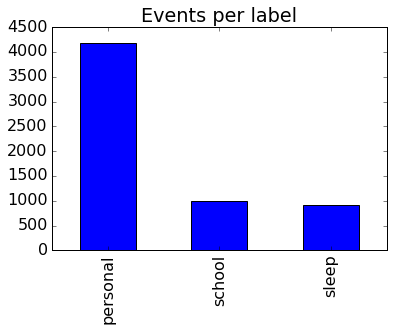

In [38]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd

import utils

pd.set_option('display.width', 1000)
matplotlib.rcParams.update({'font.size': 16})

data = pd.read_table('data/processed_events.txt', sep=' ').sample(frac=1)
# data = data.loc[data['label'] != 'sleep', :]
# data = data.loc[:, data.columns != 'day_number']
# data = data.loc[:, data.columns != 'weekday']
print(data.head(10))

X = data.iloc[:, 1:-1].as_matrix()
print('Features X')
print(X)

y = data['label']
label_to_int = {'personal': 0, 'school': 1, 'sleep': 2}
labels = [lab_name for lab_name, i in sorted(label_to_int.items(), key=lambda x: x[1])]
y = np.array([label_to_int[label] for label in y])
print('Labels y')
print(y)

print(utils.count_freqs(y))

data['label'].value_counts().plot(kind='bar')
plt.title('Events per label')
plt.show()


# Part 1: Simple visualization based on metadata
Try to do some simple visualization based on metadata (do not use summaries).

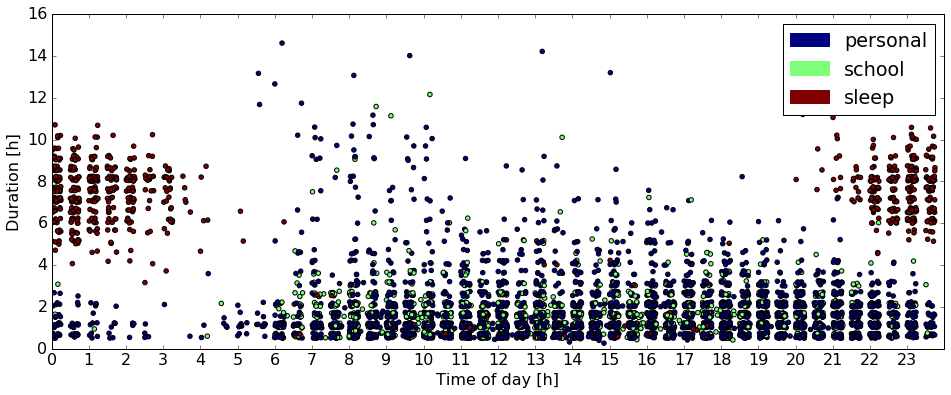

In [22]:
fig = plt.figure(figsize=(16, 6))
e = np.random.rand(len(y), 2) / 4 
plt.scatter(data['minutes_of_day'] / 60 + e[:, 0], data['duration_minutes'] / 60 + e[:, 1], c=y)
plt.xlim(0,24)
plt.ylim(0,16)
plt.xlabel('Time of day [h]')
plt.ylabel('Duration [h]')
plt.xticks(range(24))
utils.category_legend(label_to_int)
plt.show()

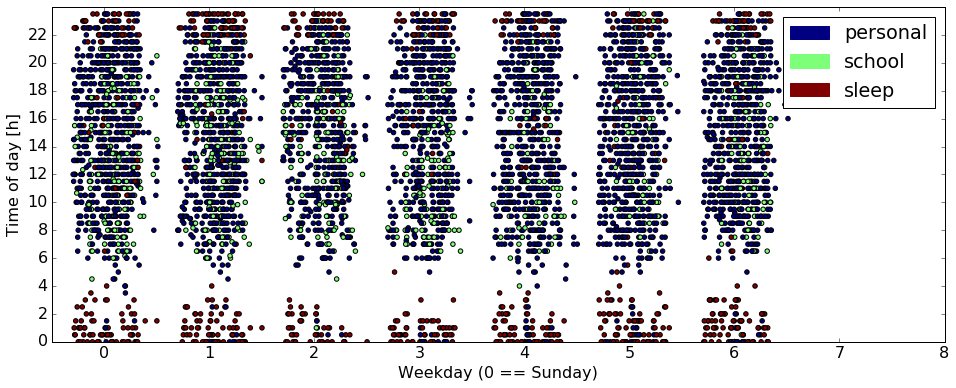

In [18]:
fig = plt.figure(figsize=(16, 6))
e = (data['day_number'] - min(data['day_number'])) / max(data['day_number'])
plt.scatter(data['weekday'] + e - 0.3 , data['minutes_of_day'] / 60, c=y)
plt.xlim(-0.5, 8)
plt.ylim(0,24)
plt.xlabel('Weekday (0 == Sunday)')
plt.ylabel('Time of day [h]')
plt.yticks(range(0, 24, 2))
utils.category_legend(label_to_int)
plt.show()

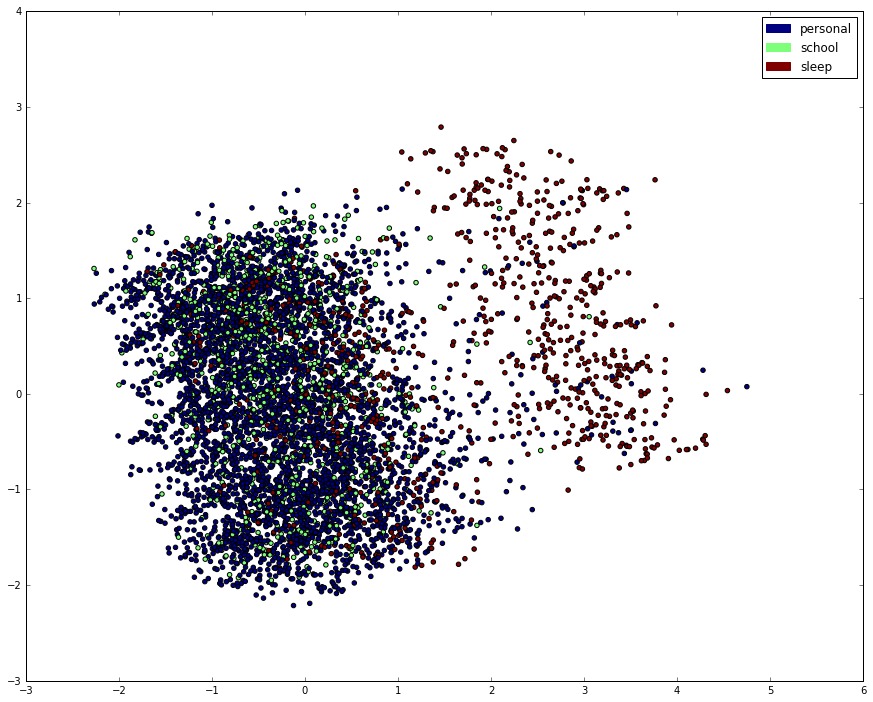

In [60]:
from sklearn.decomposition import PCA

nX = utils.normalize(X)

pca = PCA(n_components=2)
transformed = pca.fit_transform(nX)

fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(111)

plt.scatter(transformed[:, 0], transformed[:, 1], c=y)

# labels = [label if np.random.rand() > 0.997 else '' for label in data['summary']]
# utils.label_points(ax, transformed[:, 0], transformed[:, 1], labels)
utils.category_legend(label_to_int)

plt.show()

In [61]:
print(pca.components_)
print(pca.explained_variance_ratio_)

[[-0.39968401  0.25466109 -0.59487242  0.64925128]
 [ 0.16421018 -0.91385214 -0.3409772   0.14711844]]
[ 0.32103009  0.24645674]


The most important seem to be time of day and duration, and then, in the second component the weekday.

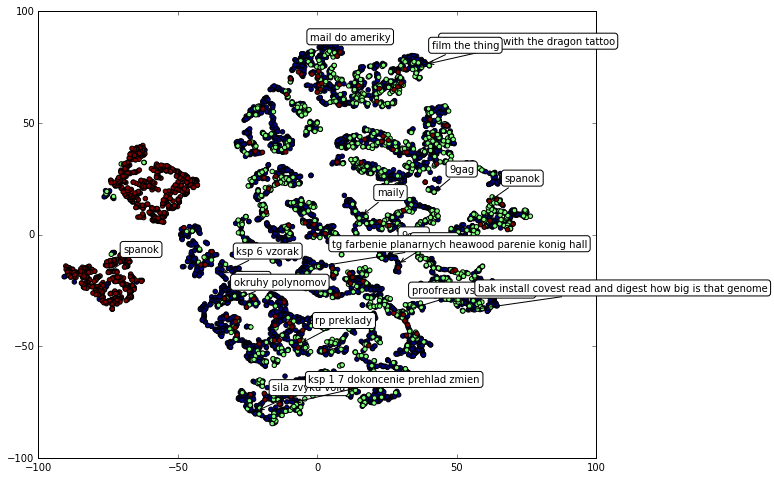

In [46]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
transformed_tsne = tsne.fit_transform(nX)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
plt.scatter(transformed_tsne[:, 0], transformed_tsne[:, 1], c=y)
# utils.label_points(ax, transformed_tsne[:, 0], transformed_tsne[:, 1], labels)
plt.show()

Sleep can be easily separated, other events create clusters.

In [3]:
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix

kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
print(confusion_matrix(y, kmeans.labels_))


[[2011 2028  133]
 [ 612  362   11]
 [  76  375  466]]


# Part 2: Simple classification
day number, weekday, start time of day, duration -> which calendar (school, personal, sleep)


In [39]:
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

kf = KFold(n_splits=5, shuffle=True, random_state=0)
splits = list(kf.split(X))

In [24]:
svc = svm.SVC(C=1, gamma=0.0001, kernel='rbf')
utils.evaluate_model(svc, X, y, splits)

Training accuracy: 0.822975014758 +/- 0.00317647364018
Testing accuracy: 0.814619290717 +/- 0.0117662658959

Training macro-F1: 0.632814640504 +/- 0.00641629970262
Testing macro-F1: 0.610927022167 +/- 0.00858051057626


Normalized confusion matrix


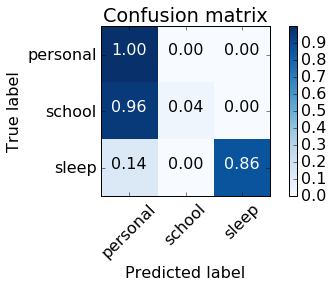

In [25]:
svc.fit(X, y)
cm = confusion_matrix(y, svc.predict(X))
utils.plot_confusion_matrix(cm, labels, normalize=True)
plt.show()

In [26]:
rfc = RandomForestClassifier(n_estimators=20, max_depth=4)
utils.evaluate_model(rfc, X, y, splits)

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training accuracy: 0.81215030951 +/- 0.00357822144129
Testing accuracy: 0.811326567278 +/- 0.0118008699879

Training macro-F1: 0.595412133878 +/- 0.00401055215156
Testing macro-F1: 0.594299923583 +/- 0.00706128641326


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Normalized confusion matrix


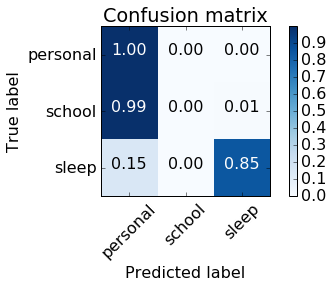

In [27]:
rfc.fit(X, y)
cm = confusion_matrix(y, rfc.predict(X))
utils.plot_confusion_matrix(cm, labels, normalize=True)
plt.show()

In [28]:
abc = AdaBoostClassifier(base_estimator=rfc, n_estimators=10)
utils.evaluate_model(abc, X, y, splits)

Training accuracy: 0.833429205657 +/- 0.0023456709124
Testing accuracy: 0.822687574999 +/- 0.0124677408061

Training macro-F1: 0.68558390008 +/- 0.00682646642248
Testing macro-F1: 0.659327883982 +/- 0.0157694396609


Normalized confusion matrix


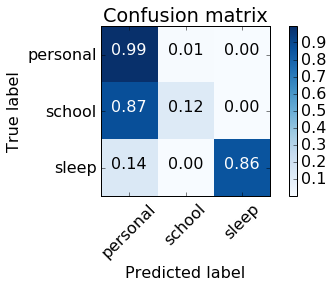

In [29]:
abc.fit(X, y)
cm = confusion_matrix(y, abc.predict(X))
utils.plot_confusion_matrix(cm, labels, normalize=True)
plt.show()

Learning for school and my other activies are undistinguishable based on metadata. 
And since there are many more examples from personal calendar, a good solution is to predict every
non-sleep event to be from personal calendar.

# Part 3: Subsample personal to have the same amount of events

In [40]:
ind = np.logical_or(data['label'] != 'personal', np.random.rand(len(y)) < 0.25)
Xs = X[ind, :]
ys = y[ind]
print(Xs.shape)
print(ys.shape)

print(utils.count_freqs(ys))

(2951, 4)
(2951,)
[(0, 1049), (1, 985), (2, 917)]


In [41]:
kf = KFold(n_splits=5, shuffle=True, random_state=0)
splits = list(kf.split(Xs))

In [42]:
svc = svm.SVC(C=1, gamma=0.00001, kernel='rbf')
utils.evaluate_model(svc, Xs, ys, splits)

Training accuracy: 0.712216347569 +/- 0.00605763965613
Testing accuracy: 0.700106111446 +/- 0.0185524703608

Training macro-F1: 0.725232123722 +/- 0.00587430748184
Testing macro-F1: 0.713652335343 +/- 0.0185462340164


Accuracy on all data: 0.666776424103
Normalized confusion matrix


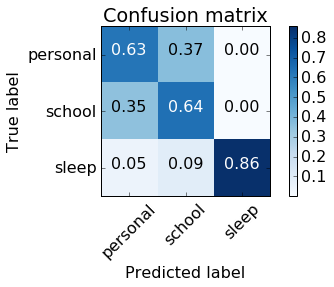

In [46]:
svc.fit(Xs, ys)
print('Accuracy on all data:', svc.score(X, y))
cm = confusion_matrix(y, svc.predict(X))
utils.plot_confusion_matrix(cm, labels, normalize=True)
plt.show()

In [34]:
rfc = RandomForestClassifier(n_estimators=20, max_depth=4)
utils.evaluate_model(rfc, Xs, ys, splits)

Training accuracy: 0.723194620668 +/- 0.00870061620918
Testing accuracy: 0.699100117049 +/- 0.021068777134

Training macro-F1: 0.731778197884 +/- 0.0071314830418
Testing macro-F1: 0.707901861632 +/- 0.0184950739389


Normalized confusion matrix


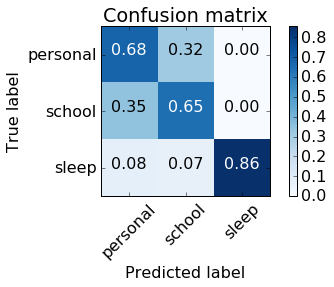

In [37]:
rfc.fit(Xs, ys)
cm = confusion_matrix(ys, rfc.predict(Xs))
utils.plot_confusion_matrix(cm, labels, normalize=True)
plt.show()